# BMW


用户流失分析

In [1]:
from copy import deepcopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, export_graphviz
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, recall_score
import joblib
# import graphviz
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

## 加载数据


使用openpyxl引擎

In [2]:
bmw_data = pd.read_excel('data.xlsx', engine='openpyxl')
bmw_data

,车架号,客户是否流失,客户价值分类,R值,F值,M值,车系,车型,车龄,车龄（天）,...,过去一年进店次数（内部）,过去一年进店消费（内部）,过去一年进店次数（Total）,过去一年进店消费（Total）,历史进店次数（internal）,历史进店消费（internal）,历史进店次数（Total）,历史进店消费（Total）,全网-历史进店次数（internal）,全网-历史进店消费（internal）
0,LBVH*843,1.0,3,1,0,1,X1,X1 20LI,3,1095,...,0,NaN,1,6549.17,0,NaN,1,6549.17,1,0.00
1,LBVP*583,0.0,6,0,1,0,3 Series,320I A,13,4745,...,0,NaN,0,0.00,10,1400.88,31,104779.32,10,1400.88
2,LBV3*060,1.0,8,0,0,0,3 Series,320I A,7,2555,...,0,NaN,0,0.00,0,NaN,6,24695.27,0,NaN
3,LBVF*605,1.0,2,1,1,0,5 Series,523I A,10,3650,...,0,NaN,1,2037.77,6,1178.84,25,83028.25,6,1178.84
4,LBVH*012,0.0,8,0,0,0,X1,X1 20LI,3,1095,...,0,NaN,0,0.00,0,NaN,1,287.10,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33874,WBAV*055,NaN,6,0,1,0,X1,X20I A,10,3650,...,0,NaN,0,0.00,5,2115.95,18,55607.31,5,2115.95
33875,WBA8*891,NaN,8,0,0,0,3 Series,320I A,2,730,...,0,NaN,0,0.00,0,NaN,1,350.90,1,980.17
33876,WBAW*641,NaN,2,1,1,0,X3,X3 20I A,7,2555,...,1,1203.09,2,1203.07,5,3419.43,12,5470.58,5,3419.43
33877,LBV8*337,NaN,6,0,1,0,3 Series,330I A,4,1460,...,0,NaN,0,0.00,2,2631.98,5,11320.80,3,2631.98


## 处理字段


去除无用的字段

> 车架号是名义变量，还没有什么实际作用，需要去除
> RFM的值是最终结果需要去除


把时间转成time格式

> *本店最后一次进店日期*和*保修起始日期*需要转成数字的time格式


所有的空值补0


只有前5000条数据打标了，就是设置了客户是否流失，所以取出前5000条数据

In [3]:
bmw_data_dev = bmw_data.drop(columns=['车架号','客户价值分类', 'R值', 'F值', 'M值'])
bmw_data_dev['本店最后一次进店日期'] = bmw_data_dev['本店最后一次进店日期'].apply(lambda x:x.value)
bmw_data_dev['保修起始日期'] = bmw_data_dev['保修起始日期'].apply(lambda x:x.value)
bmw_data_dev = bmw_data_dev[:4999].fillna(0)
bmw_data_dev

,客户是否流失,车系,车型,车龄,车龄（天）,是否NEV/PHEV,里程,保修起始日期,距离下一次续保天数,本店最后一次进店日期,...,过去一年进店次数（内部）,过去一年进店消费（内部）,过去一年进店次数（Total）,过去一年进店消费（Total）,历史进店次数（internal）,历史进店消费（internal）,历史进店次数（Total）,历史进店消费（Total）,全网-历史进店次数（internal）,全网-历史进店消费（internal）
0,1.0,X1,X1 20LI,3,1095,0,15599,1574899200000000000,211.0,1637539200000000000,...,0,0.00,1,6549.17,0,0.00,1,6549.17,1,0.00
1,0.0,3 Series,320I A,13,4745,0,100236,1259539200000000000,211.0,1603929600000000000,...,0,0.00,0,0.00,10,1400.88,31,104779.32,10,1400.88
2,1.0,3 Series,320I A,7,2555,0,32989,1438819200000000000,96.0,1609977600000000000,...,0,0.00,0,0.00,0,0.00,6,24695.27,0,0.00
3,1.0,5 Series,523I A,10,3650,0,115782,1345852800000000000,115.0,1632614400000000000,...,0,0.00,1,2037.77,6,1178.84,25,83028.25,6,1178.84
4,0.0,X1,X1 20LI,3,1095,0,9398,1585267200000000000,331.0,1585180800000000000,...,0,0.00,0,0.00,0,0.00,1,287.10,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,1.0,X7,X7 40I,3,1095,0,67167,1571184000000000000,168.0,1644278400000000000,...,1,0.00,4,18802.40,1,0.00,8,28531.05,1,0.00
4995,0.0,3 Series,320LI A,5,1825,0,47163,1498521600000000000,57.0,1592438400000000000,...,0,0.00,0,0.00,1,0.00,4,11355.67,1,0.00
4996,1.0,5 Series,525LI,1,365,0,10,1623888000000000000,48.0,1623801600000000000,...,1,11769.91,2,12152.71,1,11769.91,2,12152.71,1,11769.91
4997,0.0,3 Series,320I A,6,2190,0,31124,1487894400000000000,299.0,1600992000000000000,...,0,0.00,0,0.00,1,263.73,11,39647.54,2,263.73


### 拆分测试训练数据


总共5000条数据，4000条用来做训练以及测试


留下1000条做最后的预测对比

In [4]:
bmw_data_truly = bmw_data_dev[4000:]
bmw_data_truly

,客户是否流失,车系,车型,车龄,车龄（天）,是否NEV/PHEV,里程,保修起始日期,距离下一次续保天数,本店最后一次进店日期,...,过去一年进店次数（内部）,过去一年进店消费（内部）,过去一年进店次数（Total）,过去一年进店消费（Total）,历史进店次数（internal）,历史进店消费（internal）,历史进店次数（Total）,历史进店消费（Total）,全网-历史进店次数（internal）,全网-历史进店消费（internal）
4000,1.0,5 Series,530LE A,4,1460,1,83429,1545696000000000000,238.0,1636588800000000000,...,2,708.05,4,4340.47,5,5498.53,13,20339.11,6,5498.53
4001,1.0,7 Series,740I,9,3285,0,152966,1373500800000000000,74.0,1644883200000000000,...,0,0.00,2,16994.58,11,6587.82,28,128947.31,11,6587.82
4002,1.0,5 Series,530LI,1,365,0,10632,1630454400000000000,124.0,1646352000000000000,...,1,11769.91,3,13119.59,1,11769.91,3,13119.59,1,11769.91
4003,1.0,X1,X1 20LI,1,365,0,0,1638403200000000000,216.0,1638316800000000000,...,1,11770.49,2,12089.49,1,11770.49,2,12089.49,1,11770.49
4004,1.0,5 Series,530LI A,3,1095,0,50089,1559347200000000000,31.0,1600560000000000000,...,0,0.00,0,0.00,0,0.00,1,1127.90,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,1.0,X7,X7 40I,3,1095,0,67167,1571184000000000000,168.0,1644278400000000000,...,1,0.00,4,18802.40,1,0.00,8,28531.05,1,0.00
4995,0.0,3 Series,320LI A,5,1825,0,47163,1498521600000000000,57.0,1592438400000000000,...,0,0.00,0,0.00,1,0.00,4,11355.67,1,0.00
4996,1.0,5 Series,525LI,1,365,0,10,1623888000000000000,48.0,1623801600000000000,...,1,11769.91,2,12152.71,1,11769.91,2,12152.71,1,11769.91
4997,0.0,3 Series,320I A,6,2190,0,31124,1487894400000000000,299.0,1600992000000000000,...,0,0.00,0,0.00,1,263.73,11,39647.54,2,263.73


In [5]:
bmw_data_dev = bmw_data_dev[:4000]
bmw_data_dev

,客户是否流失,车系,车型,车龄,车龄（天）,是否NEV/PHEV,里程,保修起始日期,距离下一次续保天数,本店最后一次进店日期,...,过去一年进店次数（内部）,过去一年进店消费（内部）,过去一年进店次数（Total）,过去一年进店消费（Total）,历史进店次数（internal）,历史进店消费（internal）,历史进店次数（Total）,历史进店消费（Total）,全网-历史进店次数（internal）,全网-历史进店消费（internal）
0,1.0,X1,X1 20LI,3,1095,0,15599,1574899200000000000,211.0,1637539200000000000,...,0,0.0,1,6549.17,0,0.00,1,6549.17,1,0.00
1,0.0,3 Series,320I A,13,4745,0,100236,1259539200000000000,211.0,1603929600000000000,...,0,0.0,0,0.00,10,1400.88,31,104779.32,10,1400.88
2,1.0,3 Series,320I A,7,2555,0,32989,1438819200000000000,96.0,1609977600000000000,...,0,0.0,0,0.00,0,0.00,6,24695.27,0,0.00
3,1.0,5 Series,523I A,10,3650,0,115782,1345852800000000000,115.0,1632614400000000000,...,0,0.0,1,2037.77,6,1178.84,25,83028.25,6,1178.84
4,0.0,X1,X1 20LI,3,1095,0,9398,1585267200000000000,331.0,1585180800000000000,...,0,0.0,0,0.00,0,0.00,1,287.10,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1.0,3 Series,320I A,6,2190,0,70383,1466985600000000000,57.0,1650240000000000000,...,0,0.0,2,5133.60,0,0.00,2,5133.60,1,0.00
3996,0.0,3 Series,325LI,2,730,0,25547,1604448000000000000,188.0,1646179200000000000,...,0,0.0,1,1340.75,0,0.00,1,1340.75,3,869.01
3997,1.0,3 Series,320I A,9,3285,0,23259,1388016000000000000,238.0,1598918400000000000,...,0,0.0,0,0.00,1,0.00,8,31618.90,2,288.96
3998,1.0,3 Series,325LI,3,1095,0,14377,1573516800000000000,195.0,1642204800000000000,...,0,0.0,1,4071.11,0,0.00,1,4071.11,3,1427.64


## 预处理


数据需要预处理


> 名义变量需要做onehot
> 数字比较大的要做standard

In [6]:
preprocessor = ColumnTransformer([
  ('int', 'passthrough', make_column_selector(dtype_include=np.int64)),
  ('float', StandardScaler(), make_column_selector(dtype_include=np.float64)),
  ('onehot', OneHotEncoder(handle_unknown='ignore', dtype=int), ['车系','车型'])
])
preprocessor.fit(bmw_data_dev)
preprocessor.named_transformers_['onehot'].get_feature_names(['车系','车型'])

array(['车系_1 Series', '车系_2 Series', '车系_3 Series', '车系_4 Series',
       '车系_5 Series', '车系_6 Series', '车系_7 Series', '车系_8 Series',
       '车系_BMWi', '车系_X1', '车系_X2', '车系_X3', '车系_X4', '车系_X5', '车系_X6',
       '车系_X7', '车系_Z Series', '车型_116I A', '车型_118I A', '车型_120I',
       '车型_120I A', '车型_125I', '车型_125I A', '车型_15I', '车型_20I A',
       '车型_218I A', '车型_220I', '车型_220I A', '车型_225I', '车型_225I A',
       '车型_23E', '车型_23I A', '车型_316I A', '车型_316LI A', '车型_318I A',
       '车型_318LI A', '车型_320I', '车型_320I A', '车型_320I CN A', '车型_320LI',
       '车型_320LI A', '车型_325I', '车型_325I A', '车型_325I CN A', '车型_325LI',
       '车型_328I', '车型_328I A', '车型_328LI', '车型_328LI A', '车型_330I A',
       '车型_330LI', '车型_330LI A', '车型_35I', '车型_420I A', '车型_425I',
       '车型_425I A', '车型_428I A', '车型_430I', '车型_430I A', '车型_520I A',
       '车型_523I A', '车型_525I A', '车型_525LI', '车型_525LI A', '车型_528I',
       '车型_528I A', '车型_528LI A', '车型_530I A', '车型_530LE A', '车型_530LI',
       '车型_530LI A', '车型_53

In [7]:
preprocessor.transform(bmw_data_dev)

<4000x182 sparse matrix of type '<class 'numpy.float64'>'
	with 92985 stored elements in Compressed Sparse Row format>

In [8]:
bmw_data_dev.select_dtypes(np.int64).columns

Index(['车龄', '车龄（天）', '是否NEV/PHEV', '里程', '保修起始日期', '本店最后一次进店日期', '本店最近进店间隔天数',
       '最后一次是否在本店', '是否迁徙', '全网-过去一年进店次数（内部）', '全网-过去一年进店次数（Total）',
       '过去一年进店次数（内部）', '过去一年进店次数（Total）', '历史进店次数（internal）', '历史进店次数（Total）',
       '全网-历史进店次数（internal）'],
      dtype='object')

In [9]:
bmw_data_dev.select_dtypes(np.float64).columns

Index(['客户是否流失', '距离下一次续保天数', '全网-过去一年进店消费（internal）', '全网-过去一年进店消费（Total）',
       '过去一年进店消费（内部）', '过去一年进店消费（Total）', '历史进店消费（internal）', '历史进店消费（Total）',
       '全网-历史进店消费（internal）'],
      dtype='object')

## 模型选择


创建流水线


对比模型的10组数据

In [35]:
scorelist = pd.DataFrame()
models = {
  'svm': SVC(),
  'tree': DecisionTreeClassifier(),
  'neural': MLPClassifier(random_state=1, max_iter=100)
}
for key, model in models.items():
  my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
  ])
  scorelist[key] = cross_val_score(my_pipeline, bmw_data_dev.drop(columns=['客户是否流失']), bmw_data_dev['客户是否流失'], cv=10)
scorelist

c:\Users\Thales\anaconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\Users\Thales\anaconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\Users\Thales\anaconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\Users\Thales\anaconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't co

,svm,tree,neural
0,0.7150,0.9475,0.7150
1,0.7175,0.9550,0.7150
2,0.7200,0.9675,0.7025
3,0.7150,0.9600,0.7150
4,0.7150,0.9825,0.6875
5,0.7150,0.9800,0.7125
6,0.7125,0.9875,0.7125
7,0.7125,0.9800,0.7150
8,0.7125,0.9775,0.7125
9,0.7125,0.9750,0.7125


用图形展示


> 可以看出svm和决策树相对平稳，决策树的数据又更好看一些

<AxesSubplot:>

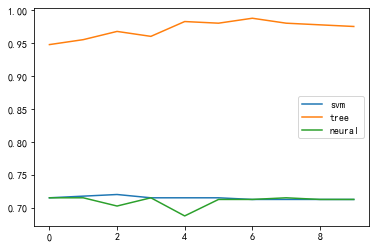

In [36]:
scorelist.plot()

## 决策树参数对比


最终使用决策树模型对比一下不同的criterion

In [12]:
tree_scores = pd.DataFrame()
models = {
  'gini': DecisionTreeClassifier(criterion="gini", random_state=1),
  'entropy': DecisionTreeClassifier(criterion="entropy", random_state=1)
}
for key, model in models.items():
  my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
  ])
  tree_scores[key] = cross_val_score(my_pipeline, bmw_data_dev.drop(columns=['客户是否流失']), bmw_data_dev['客户是否流失'], cv=10)
tree_scores

,gini,entropy
0,0.9500,0.9400
1,0.9575,0.9575
2,0.9700,0.9575
3,0.9625,0.9525
4,0.9875,0.9825
5,0.9725,0.9775
6,0.9825,0.9825
7,0.9750,0.9825
8,0.9775,0.9875
9,0.9775,0.9800


<AxesSubplot:>

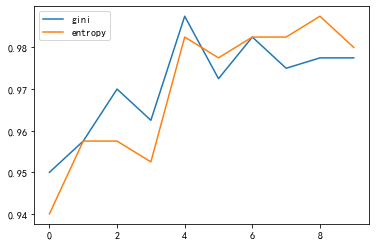

In [13]:
tree_scores.plot()

## 构建模型


构建数据最合适的模型

In [14]:
clf = Pipeline(steps=[
  ('preprocessor', preprocessor),
  ('model', DecisionTreeClassifier(criterion='gini'))
])
clf.fit(bmw_data_dev.drop(columns=['客户是否流失']), bmw_data_dev['客户是否流失'])

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('int', 'passthrough',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E45E7F5748>),
                                                 ('float',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  <sklearn.compose._column_tra...
                                                  ['车系', '车型'])],
                                   verbose=False)),
                ('model',
                 DecisionT

## 测试模型


用测试数据来验证模型准确率

In [15]:
clf.score(bmw_data_truly.drop(columns=['客户是否流失']), bmw_data_truly['客户是否流失'])

0.975975975975976

## 预测


训练好模型之后，用1000条数据做预测

In [16]:
pre_data = deepcopy(bmw_data_truly)
pre_data['预测结果'] = clf.predict(bmw_data_truly.drop(columns=['客户是否流失']))
pre_data

,客户是否流失,车系,车型,车龄,车龄（天）,是否NEV/PHEV,里程,保修起始日期,距离下一次续保天数,本店最后一次进店日期,...,过去一年进店消费（内部）,过去一年进店次数（Total）,过去一年进店消费（Total）,历史进店次数（internal）,历史进店消费（internal）,历史进店次数（Total）,历史进店消费（Total）,全网-历史进店次数（internal）,全网-历史进店消费（internal）,预测结果
4000,1.0,5 Series,530LE A,4,1460,1,83429,1545696000000000000,238.0,1636588800000000000,...,708.05,4,4340.47,5,5498.53,13,20339.11,6,5498.53,1.0
4001,1.0,7 Series,740I,9,3285,0,152966,1373500800000000000,74.0,1644883200000000000,...,0.00,2,16994.58,11,6587.82,28,128947.31,11,6587.82,1.0
4002,1.0,5 Series,530LI,1,365,0,10632,1630454400000000000,124.0,1646352000000000000,...,11769.91,3,13119.59,1,11769.91,3,13119.59,1,11769.91,1.0
4003,1.0,X1,X1 20LI,1,365,0,0,1638403200000000000,216.0,1638316800000000000,...,11770.49,2,12089.49,1,11770.49,2,12089.49,1,11770.49,1.0
4004,1.0,5 Series,530LI A,3,1095,0,50089,1559347200000000000,31.0,1600560000000000000,...,0.00,0,0.00,0,0.00,1,1127.90,0,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,1.0,X7,X7 40I,3,1095,0,67167,1571184000000000000,168.0,1644278400000000000,...,0.00,4,18802.40,1,0.00,8,28531.05,1,0.00,1.0
4995,0.0,3 Series,320LI A,5,1825,0,47163,1498521600000000000,57.0,1592438400000000000,...,0.00,0,0.00,1,0.00,4,11355.67,1,0.00,0.0
4996,1.0,5 Series,525LI,1,365,0,10,1623888000000000000,48.0,1623801600000000000,...,11769.91,2,12152.71,1,11769.91,2,12152.71,1,11769.91,1.0
4997,0.0,3 Series,320I A,6,2190,0,31124,1487894400000000000,299.0,1600992000000000000,...,0.00,0,0.00,1,263.73,11,39647.54,2,263.73,0.0


## 输出文件


输出文件到predication.xlsx

In [17]:
pre_data.to_excel('tree.xlsx')
accuracy_score(pre_data['客户是否流失'], pre_data['预测结果'])

0.975975975975976

## 保存模型


保存之后不用再训练

In [18]:
joblib.dump(clf, './tree.pkl')

['./tree.pkl']

## 查看树


查看树形图

In [19]:
transform_cols = np.append(
  np.append(
    bmw_data_dev.select_dtypes(np.int64).columns,
    bmw_data_dev.drop(columns=['客户是否流失']).select_dtypes(np.float64).columns
  ),
  preprocessor.named_transformers_['onehot'].get_feature_names(['车系','车型'])
)
transform_cols

array(['车龄', '车龄（天）', '是否NEV/PHEV', '里程', '保修起始日期', '本店最后一次进店日期',
       '本店最近进店间隔天数', '最后一次是否在本店', '是否迁徙', '全网-过去一年进店次数（内部）',
       '全网-过去一年进店次数（Total）', '过去一年进店次数（内部）', '过去一年进店次数（Total）',
       '历史进店次数（internal）', '历史进店次数（Total）', '全网-历史进店次数（internal）',
       '距离下一次续保天数', '全网-过去一年进店消费（internal）', '全网-过去一年进店消费（Total）',
       '过去一年进店消费（内部）', '过去一年进店消费（Total）', '历史进店消费（internal）',
       '历史进店消费（Total）', '全网-历史进店消费（internal）', '车系_1 Series',
       '车系_2 Series', '车系_3 Series', '车系_4 Series', '车系_5 Series',
       '车系_6 Series', '车系_7 Series', '车系_8 Series', '车系_BMWi', '车系_X1',
       '车系_X2', '车系_X3', '车系_X4', '车系_X5', '车系_X6', '车系_X7',
       '车系_Z Series', '车型_116I A', '车型_118I A', '车型_120I', '车型_120I A',
       '车型_125I', '车型_125I A', '车型_15I', '车型_20I A', '车型_218I A',
       '车型_220I', '车型_220I A', '车型_225I', '车型_225I A', '车型_23E',
       '车型_23I A', '车型_316I A', '车型_316LI A', '车型_318I A', '车型_318LI A',
       '车型_320I', '车型_320I A', '车型_320I CN A', '车型_320LI', '车型_320LI A',
  

[Text(1465.7198725376593, 1582.835294117647, '本店最近进店间隔天数 <= 649.0\ngini = 0.409\nsamples = 4000\nvalue = [1145, 2855]\nclass = 车龄（天）'),
 Text(949.6668597914253, 1486.9058823529413, '是否迁徙 <= 0.5\ngini = 0.21\nsamples = 3100\nvalue = [370, 2730]\nclass = 车龄（天）'),
 Text(556.0602549246813, 1390.9764705882353, '过去一年进店次数（内部） <= 0.5\ngini = 0.369\nsamples = 459\nvalue = [347, 112]\nclass = 车龄'),
 Text(504.33371958285056, 1295.0470588235294, '保修起始日期 <= 1.6220304083402097e+18\ngini = 0.189\nsamples = 388\nvalue = [347, 41]\nclass = 车龄'),
 Text(181.0428736964079, 1199.1176470588234, '本店最后一次进店日期 <= 1.6237152037513462e+18\ngini = 0.106\nsamples = 356\nvalue = [336, 20]\nclass = 车龄'),
 Text(129.31633835457706, 1103.1882352941175, 'gini = 0.0\nsamples = 258\nvalue = [258, 0]\nclass = 车龄'),
 Text(232.7694090382387, 1103.1882352941175, '保修起始日期 <= 1.5609024409187123e+18\ngini = 0.325\nsamples = 98\nvalue = [78, 20]\nclass = 车龄'),
 Text(181.0428736964079, 1007.2588235294118, 'gini = 0.0\nsamples = 55\nv

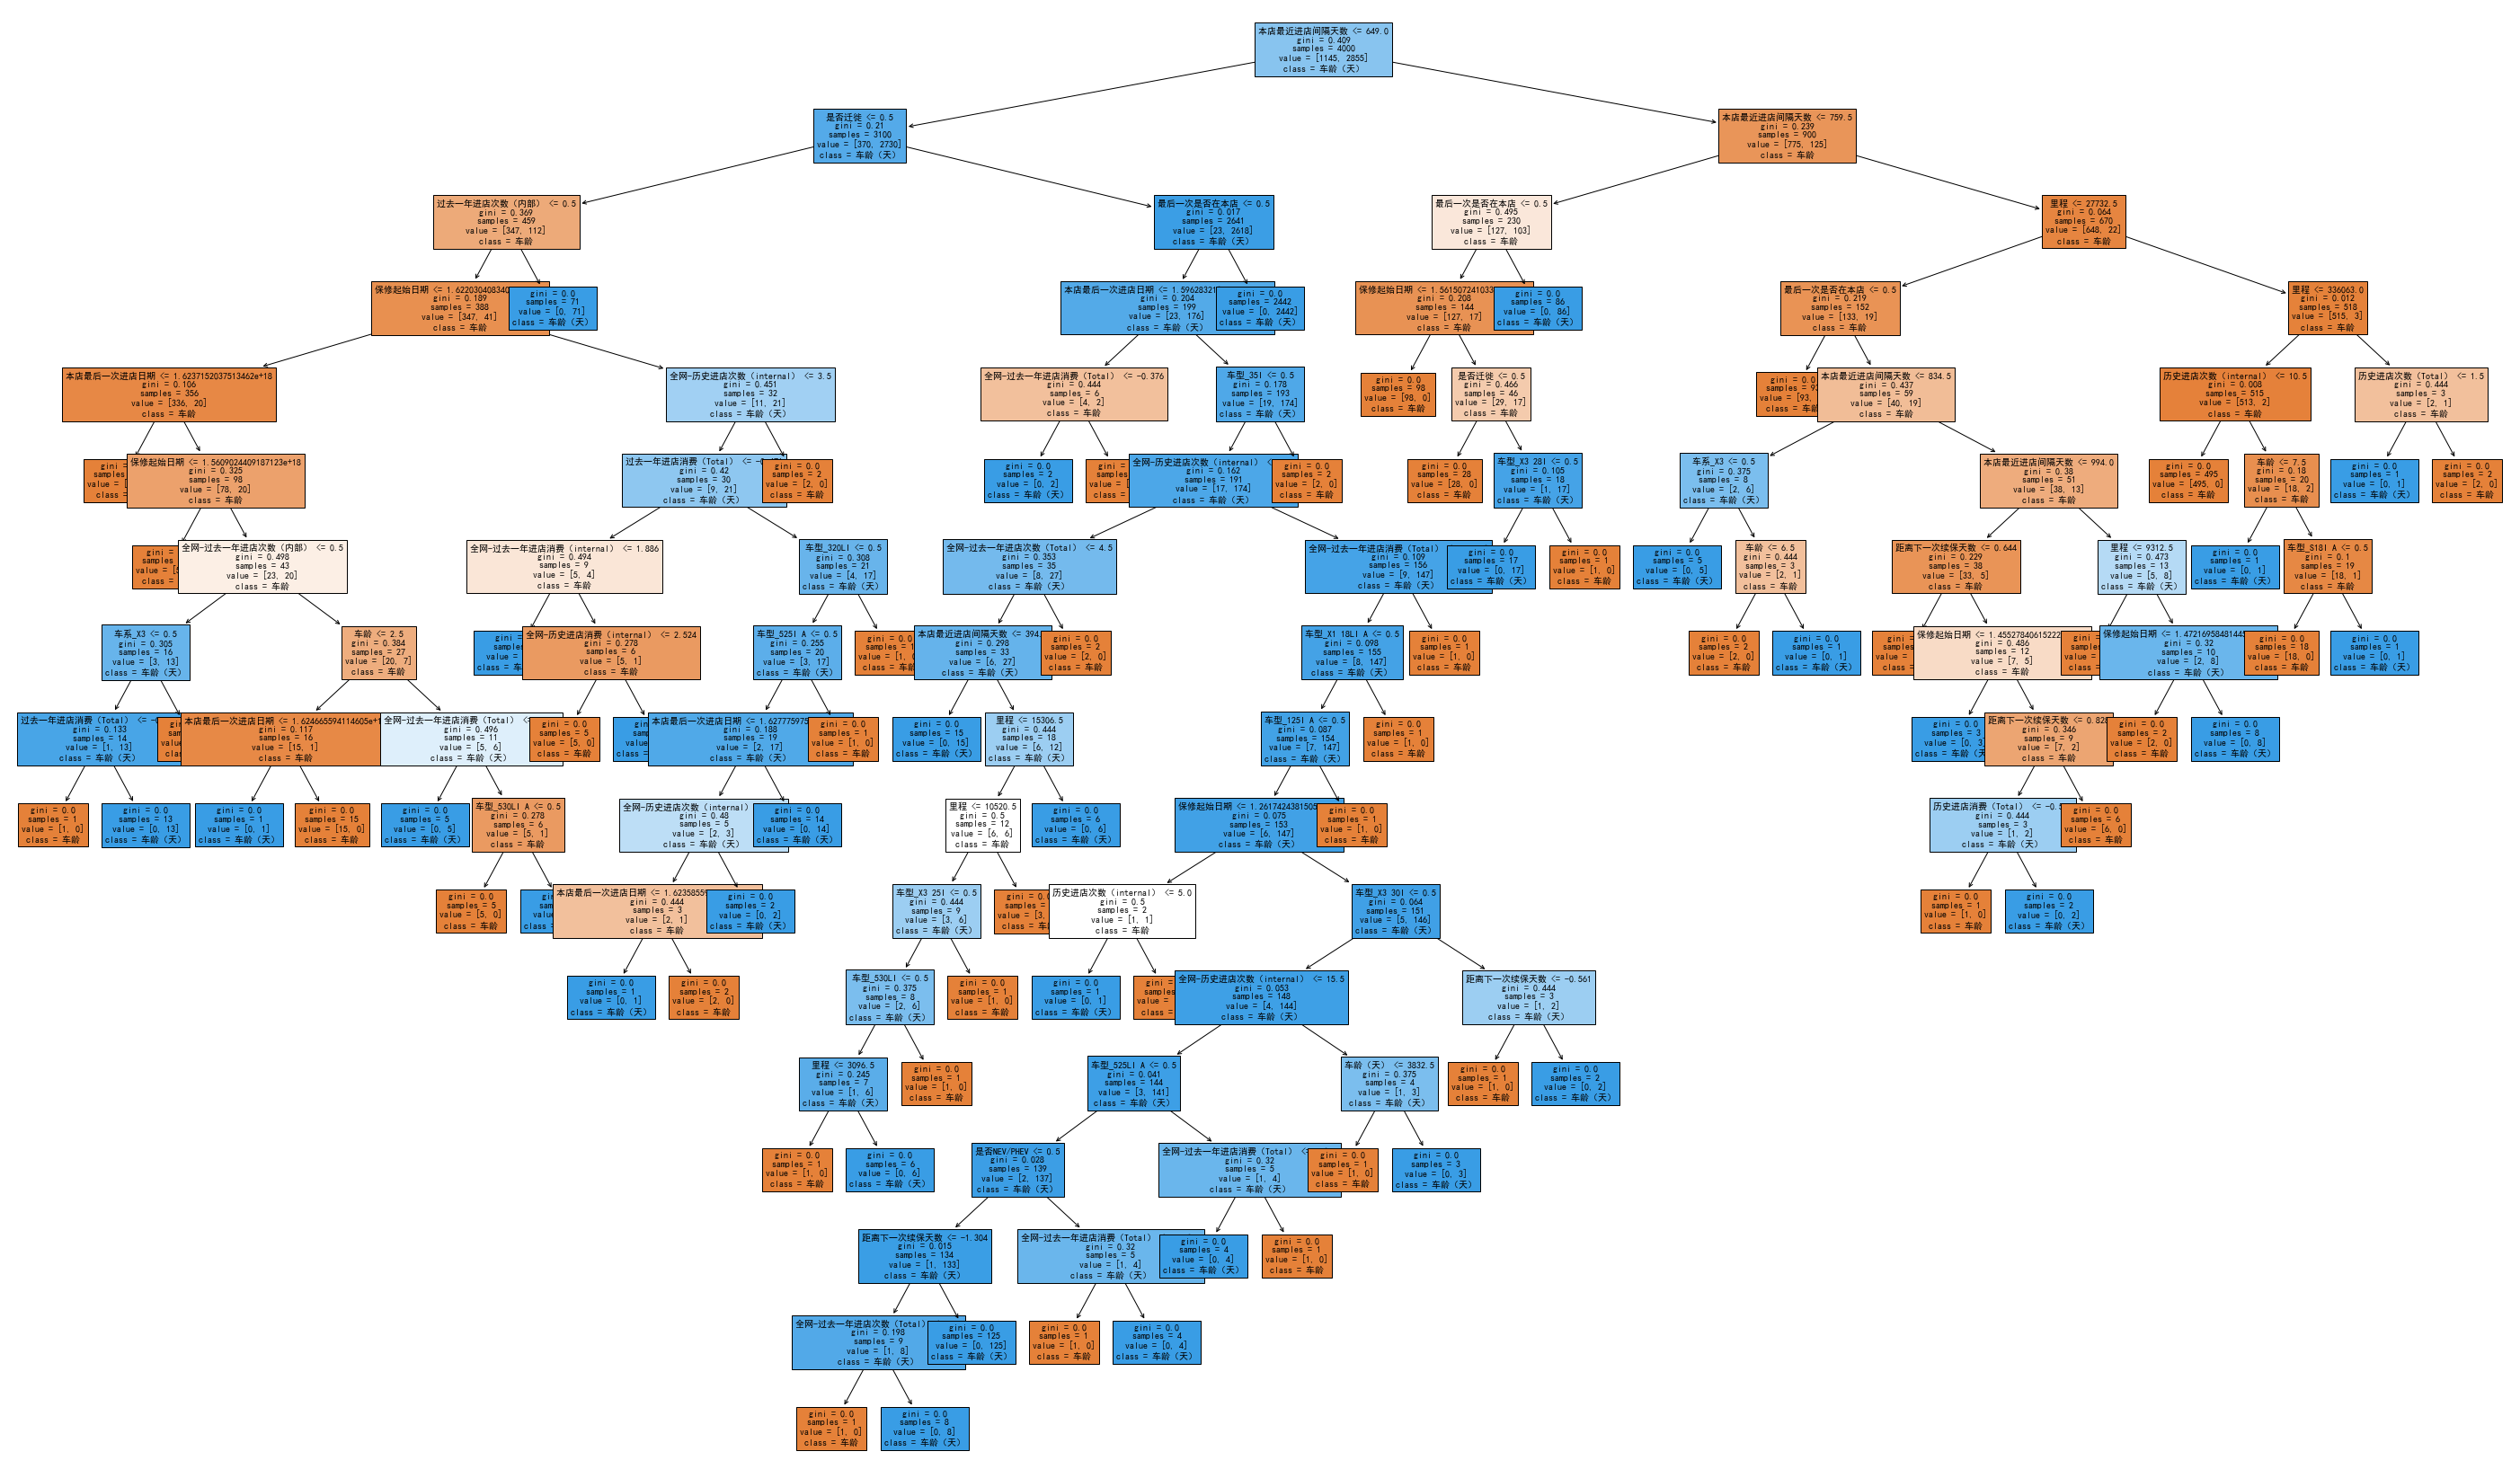

In [20]:
fig = plt.figure(figsize=(50,30))
ax = fig.add_subplot(111)
plot_tree(clf[1], ax=ax, fontsize=10, class_names=transform_cols, feature_names=transform_cols, filled=True)

## SVM


使用svm测试结果

In [21]:
svm = Pipeline(steps=[
  ('preprocessor', preprocessor),
  ('model', SVC(probability=True))
])
svm.fit(bmw_data_dev.drop(columns=['客户是否流失']), bmw_data_dev['客户是否流失'])
joblib.dump(svm, './svm.pkl')

['./svm.pkl']

In [22]:
svm.score(bmw_data_truly.drop(columns=['客户是否流失']), bmw_data_truly['客户是否流失'])

0.7207207207207207

In [34]:
pre_data = deepcopy(bmw_data_truly)
pre_data[['0概率','1概率']] = svm.predict_proba(bmw_data_truly.drop(columns=['客户是否流失']))
pre_data['预测结果'] = pre_data['1概率'] > pre_data['0概率']
pre_data['预测结果'] = pre_data['预测结果'].apply(lambda x: 1 if x else 0)
pre_data.to_excel('svm.xlsx')
pre_data

,客户是否流失,车系,车型,车龄,车龄（天）,是否NEV/PHEV,里程,保修起始日期,距离下一次续保天数,本店最后一次进店日期,...,过去一年进店消费（Total）,历史进店次数（internal）,历史进店消费（internal）,历史进店次数（Total）,历史进店消费（Total）,全网-历史进店次数（internal）,全网-历史进店消费（internal）,0概率,1概率,预测结果
4000,1.0,5 Series,530LE A,4,1460,1,83429,1545696000000000000,238.0,1636588800000000000,...,4340.47,5,5498.53,13,20339.11,6,5498.53,0.044809,0.955191,1
4001,1.0,7 Series,740I,9,3285,0,152966,1373500800000000000,74.0,1644883200000000000,...,16994.58,11,6587.82,28,128947.31,11,6587.82,0.032657,0.967343,1
4002,1.0,5 Series,530LI,1,365,0,10632,1630454400000000000,124.0,1646352000000000000,...,13119.59,1,11769.91,3,13119.59,1,11769.91,0.014219,0.985781,1
4003,1.0,X1,X1 20LI,1,365,0,0,1638403200000000000,216.0,1638316800000000000,...,12089.49,1,11770.49,2,12089.49,1,11770.49,0.030037,0.969963,1
4004,1.0,5 Series,530LI A,3,1095,0,50089,1559347200000000000,31.0,1600560000000000000,...,0.00,0,0.00,1,1127.90,0,0.00,0.607851,0.392149,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,1.0,X7,X7 40I,3,1095,0,67167,1571184000000000000,168.0,1644278400000000000,...,18802.40,1,0.00,8,28531.05,1,0.00,0.020198,0.979802,1
4995,0.0,3 Series,320LI A,5,1825,0,47163,1498521600000000000,57.0,1592438400000000000,...,0.00,1,0.00,4,11355.67,1,0.00,0.804299,0.195701,0
4996,1.0,5 Series,525LI,1,365,0,10,1623888000000000000,48.0,1623801600000000000,...,12152.71,1,11769.91,2,12152.71,1,11769.91,0.117283,0.882717,1
4997,0.0,3 Series,320I A,6,2190,0,31124,1487894400000000000,299.0,1600992000000000000,...,0.00,1,263.73,11,39647.54,2,263.73,0.644009,0.355991,0


## 全体预测

In [37]:
all_data = bmw_data.drop(columns=['车架号','客户价值分类', 'R值', 'F值', 'M值'])
all_data['本店最后一次进店日期'] = all_data['本店最后一次进店日期'].apply(lambda x:x.value)
all_data['保修起始日期'] = all_data['保修起始日期'].apply(lambda x:x.value)
all_data = all_data.fillna(0)
all_data[['0概率','1概率']] = svm.predict_proba(all_data.drop(columns=['客户是否流失']))
all_data['预测结果'] = all_data['1概率'] > all_data['0概率']
all_data['预测结果'] = all_data['预测结果'].apply(lambda x: 1 if x else 0)
all_data.to_excel('all.xlsx')